# STEP 1

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [67]:
url = 'https://data.buffalony.gov/api/views/3tj7-3tdz/rows.csv?accessType=DOWNLOAD'
df = pd.read_csv(url)
print("First few rows of the dataset:")
print(df.head())

print("Dataset Info:")
df.info()
print("\n----------------------------------------------------------------------------------------------------------------")
print("\nFirst 5 Rows:")
print(df.head())
print("\n----------------------------------------------------------------------------------------------------------------")
print("\nSummary Statistics:")
print(df.describe())

missing_values = df.isnull().sum()
print("\nMissing values in each column:")
print(missing_values[missing_values > 0])

df.dropna(subset=['Latitude', 'Longitude'], inplace=True)

First few rows of the dataset:
          Created Date  CaseNumber                     Department  \
0  05/11/2024 20:14:00      983415                  National Grid   
1  05/11/2024 19:50:00      975174                  National Grid   
2  05/22/2024 13:07:00      993956   Permit & Inspection Services   
3  05/22/2024 13:14:00      993968  Public Works, Parks & Streets   
4  06/26/2024 22:11:00     1017685  Public Works, Parks & Streets   

               Division                   Type       Status  \
0                   NaN  Streetlight(s) Issues       Closed   
1                   NaN  Streetlight(s) Issues       Closed   
2                   NaN       High Grass/Weeds  In Progress   
3           Engineering  Street Paving Request       Closed   
4  Parks and Recreation    Olmsted Parks Issue          New   

                                   StatusDescription             Closed Date  \
0                                                NaN  06/04/2024 06:19:00 PM   
1              

/var/folders/tp/5cysq2jx05n1mjwvqdsgt_v00000gn/T/ipykernel_16731/4274413895.py:2: DtypeWarning: Columns (24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


In [68]:
df['Assessed Number'] = df['Assessed Number'].fillna('Unknown')
df['AssessedStreet'] = df['AssessedStreet'].fillna('Unknown')
df['Street'] = df['Street'].fillna('Unknown')
df['City'] = df['City'].fillna('Buffalo')
df['State'] = df['State'].fillna('NY')

zip_mode = df['Zip'].mode()
if not zip_mode.empty:
    df['Zip'] = df['Zip'].fillna(zip_mode.iloc[0])
else:
    df['Zip'] = df['Zip'].fillna('Unknown')


df['Council District'] = df['Council District'].fillna('Unknown')
df['PlanningNeighborhood'] = df['PlanningNeighborhood'].fillna('Unknown')
df['PlanningSector'] = df['PlanningSector'].fillna('Unknown')
df['PoliceDistrict'] = df['PoliceDistrict'].fillna('Unknown')
df['Census Tract'] = df['Census Tract'].fillna('Unknown')
df['Census Block Group'] = df['Census Block Group'].fillna('Unknown')
df['Census Block'] = df['Census Block'].fillna('Unknown')

In [69]:
str_columns = df.select_dtypes(include=['object']).columns
df[str_columns] = df[str_columns].apply(lambda x: x.str.lower().str.strip())

In [70]:
num_columns = df.select_dtypes(include=['number']).columns
Q1 = df[num_columns].quantile(0.25)
Q3 = df[num_columns].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[~((df[num_columns] < lower_bound) | (df[num_columns] > upper_bound)).any(axis=1)]

print("\nData Info After Cleaning:")
print(df.info())
print(df.describe())
print(df.isnull().sum())


Data Info After Cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 60701 entries, 8 to 61002
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Created Date          60701 non-null  object 
 1   CaseNumber            60701 non-null  int64  
 2   Department            60700 non-null  object 
 3   Division              39880 non-null  object 
 4   Type                  60701 non-null  object 
 5   Status                60701 non-null  object 
 6   StatusDescription     53457 non-null  object 
 7   Closed Date           54951 non-null  object 
 8   PropertyID            56486 non-null  object 
 9   ReportedLocation      59879 non-null  object 
 10  Assessed Number       1468 non-null   object 
 11  AssessedStreet        60701 non-null  object 
 12  Street                60701 non-null  object 
 13  Secondary Street      4977 non-null   object 
 14  City                  60701 non-null  object 
 1

/var/folders/tp/5cysq2jx05n1mjwvqdsgt_v00000gn/T/ipykernel_16731/4131046460.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_types.index, x=top_types.values, palette="viridis")


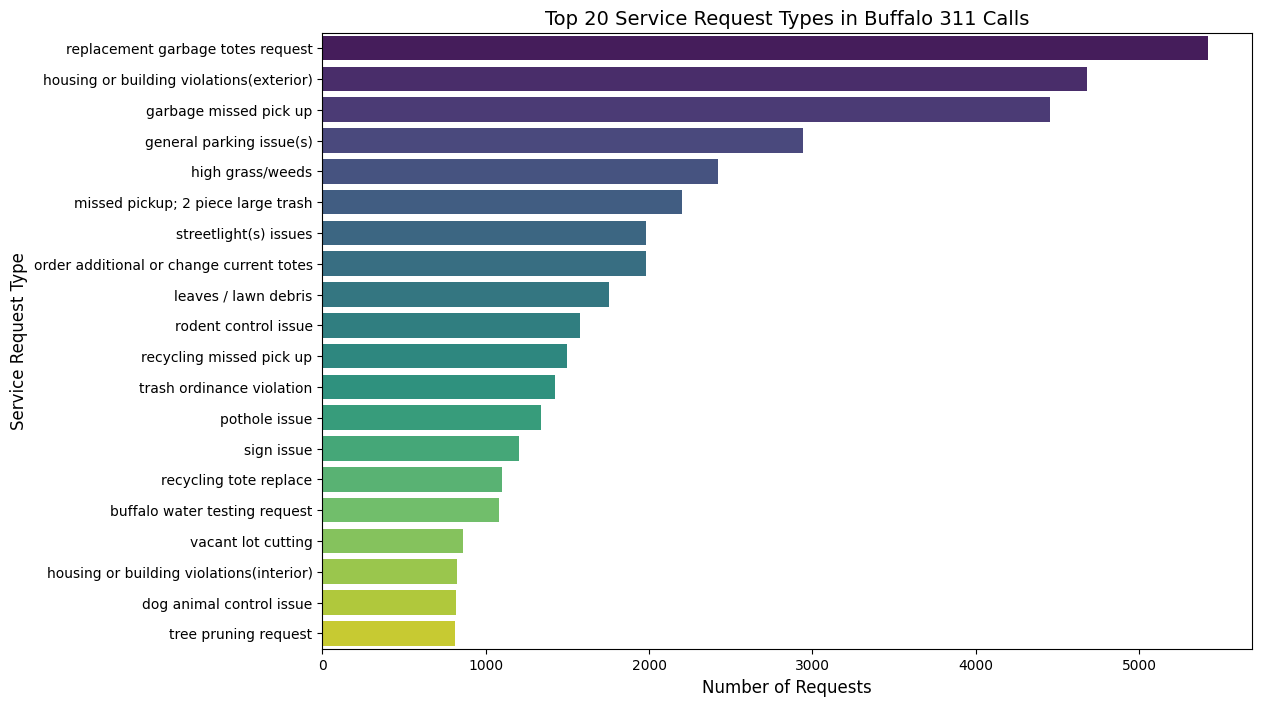

In [71]:
top_types = df['Type'].value_counts().head(20)

plt.figure(figsize=(12, 8))
sns.barplot(y=top_types.index, x=top_types.values, palette="viridis")

plt.title("Top 20 Service Request Types in Buffalo 311 Calls", fontsize=14)
plt.xlabel("Number of Requests", fontsize=12)
plt.ylabel("Service Request Type", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

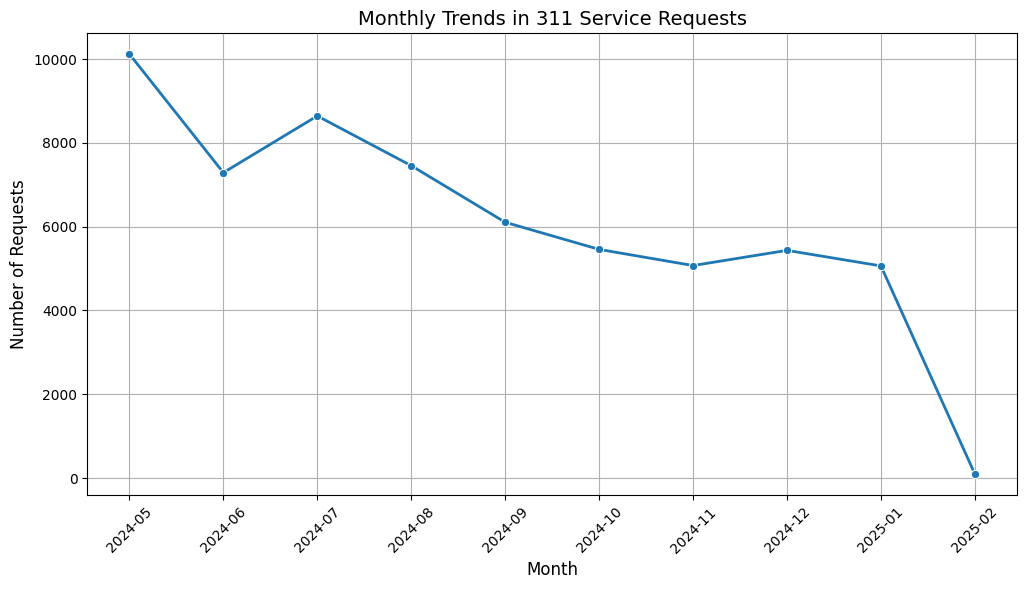

In [72]:
df['Created Date'] = pd.to_datetime(df['Created Date'], errors='coerce')

df['Month'] = df['Created Date'].dt.to_period('M')

monthly_counts = df['Month'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_counts.index.astype(str), y=monthly_counts.values, marker='o', linewidth=2)

plt.title("Monthly Trends in 311 Service Requests", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Requests", fontsize=12)

plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

plt.grid(True)
plt.show()

In [73]:

df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

df_filtered = df.dropna(subset=['Latitude', 'Longitude'])

m = folium.Map(location=[df_filtered['Latitude'].mean(), df_filtered['Longitude'].mean()], zoom_start=12)

heat_data = df_filtered[['Latitude', 'Longitude']].values.tolist()

HeatMap(heat_data, radius=12, blur=8, max_zoom=13).add_to(m)

m.save("311_service_requests_heatmap.html")

m

/var/folders/tp/5cysq2jx05n1mjwvqdsgt_v00000gn/T/ipykernel_16731/1469664386.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df['Status'], palette="coolwarm")


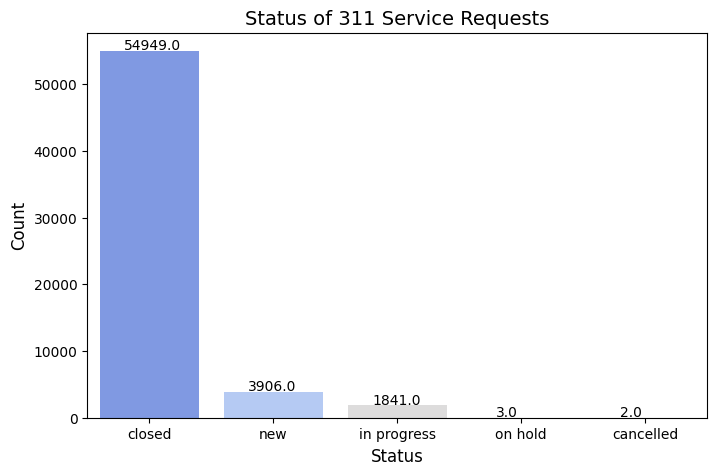

In [74]:

plt.figure(figsize=(8, 5))

ax = sns.countplot(x=df['Status'], palette="coolwarm")
plt.title("Status of 311 Service Requests", fontsize=14)
plt.xlabel("Status", fontsize=12)
plt.ylabel("Count", fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.2, p.get_height() + 200), fontsize=10, color='black')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()


/var/folders/tp/5cysq2jx05n1mjwvqdsgt_v00000gn/T/ipykernel_16731/2054751258.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_districts.index, x=top_districts.values, palette="plasma")


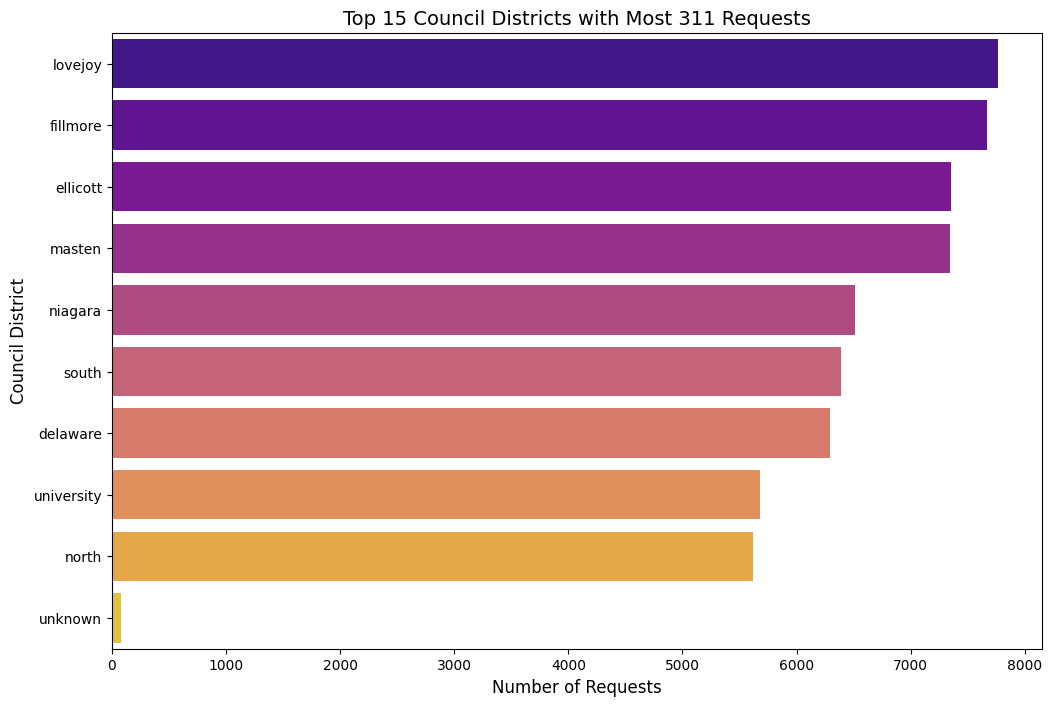

In [75]:

plt.figure(figsize=(12, 8))

top_districts = df['Council District'].value_counts().head(15)

sns.barplot(y=top_districts.index, x=top_districts.values, palette="plasma")

plt.title("Top 15 Council Districts with Most 311 Requests", fontsize=14)
plt.xlabel("Number of Requests", fontsize=12)
plt.ylabel("Council District", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

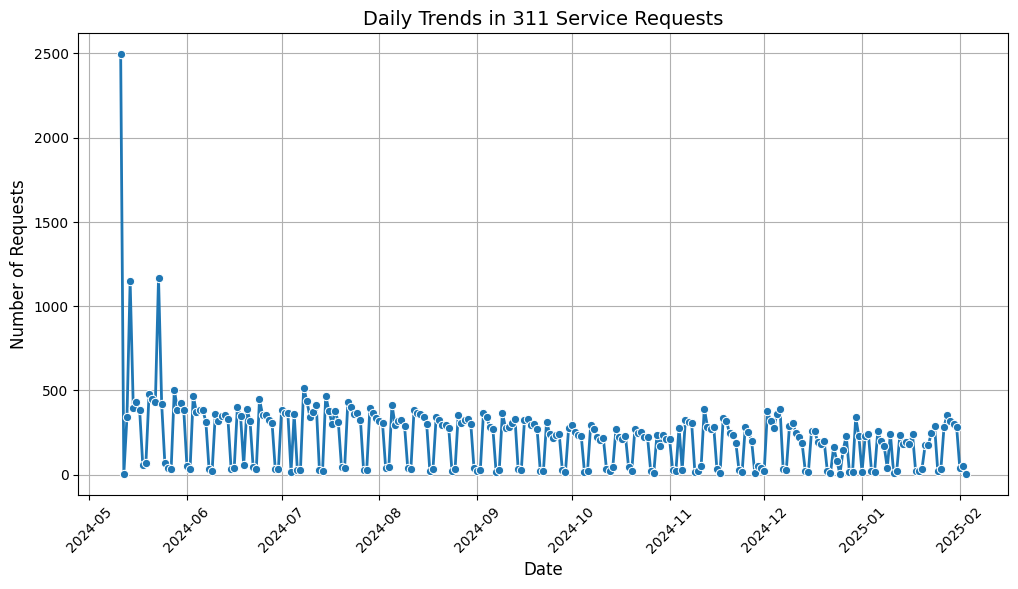

In [76]:

plt.figure(figsize=(12, 6))
df['Created Date'] = pd.to_datetime(df['Created Date'], errors='coerce')
df_daily = df.groupby(df['Created Date'].dt.date).size()

sns.lineplot(x=df_daily.index, y=df_daily.values, marker='o', linewidth=2)
plt.title("Daily Trends in 311 Service Requests", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Requests", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()


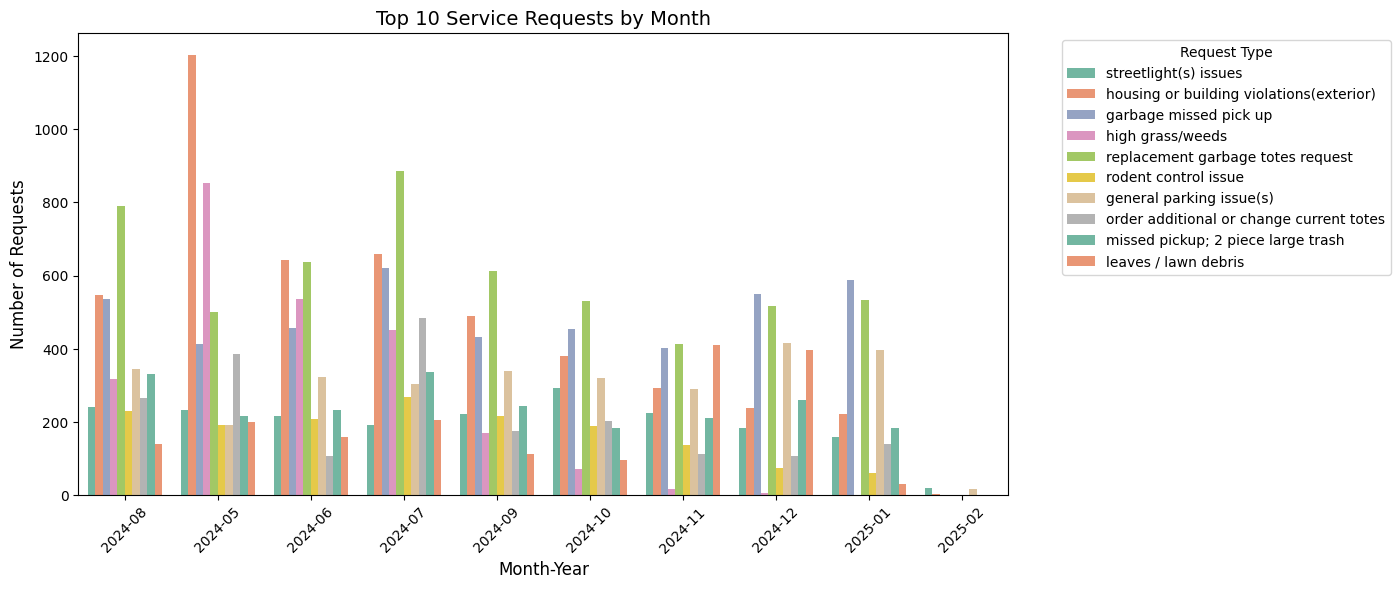

In [77]:

plt.figure(figsize=(12, 6))
df['Month-Year'] = df['Created Date'].dt.to_period('M')
top_requests = df['Type'].value_counts().head(10).index  # Top 10 types

df_filtered = df[df['Type'].isin(top_requests)]
sns.countplot(data=df_filtered, x='Month-Year', hue='Type', palette="Set2")

plt.title("Top 10 Service Requests by Month", fontsize=14)
plt.xlabel("Month-Year", fontsize=12)
plt.ylabel("Number of Requests", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Request Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/var/folders/tp/5cysq2jx05n1mjwvqdsgt_v00000gn/T/ipykernel_16731/1770170972.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Day of Week'], order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette="husl")


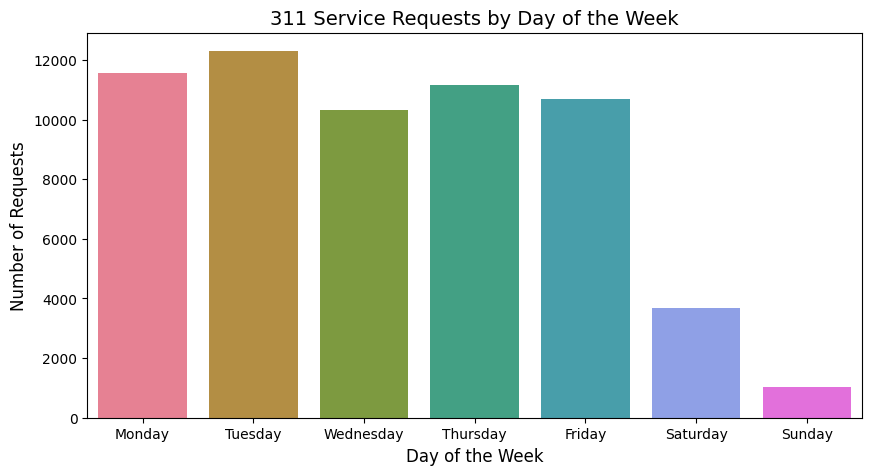

In [78]:

plt.figure(figsize=(10, 5))
df['Day of Week'] = df['Created Date'].dt.day_name()
sns.countplot(x=df['Day of Week'], order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette="husl")

plt.title("311 Service Requests by Day of the Week", fontsize=14)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Number of Requests", fontsize=12)
plt.show()


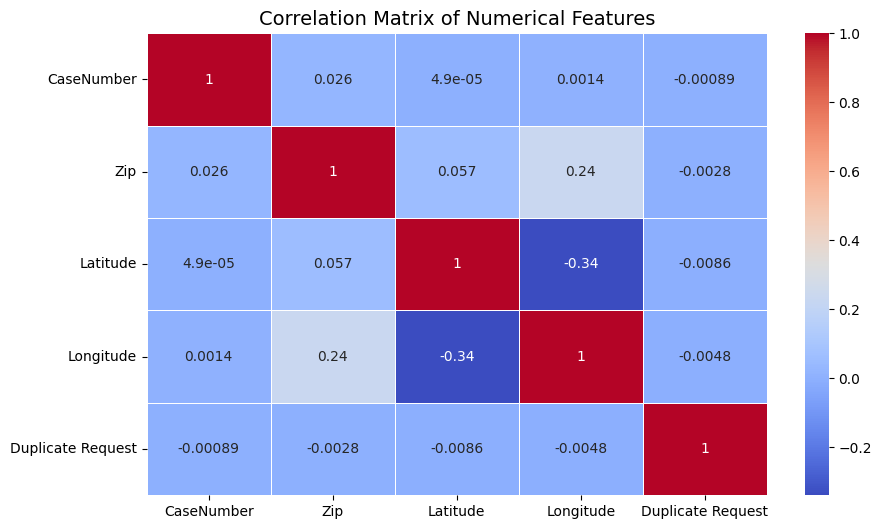

In [79]:

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features", fontsize=14)
plt.show()

In [80]:
status_mapping = {status: idx for idx, status in enumerate(df['Status'].unique())}
df['Status_encoded'] = df['Status'].map(status_mapping)
print("\nStatus Encoding Mapping:", status_mapping)

corr_matrix = df.corr(numeric_only=True)
print("Correlation Matrix:\n", corr_matrix)

features_to_drop = ["duplicate request", "latitude", "zip", "longitude", "casenumber"]
df.drop(columns=features_to_drop, inplace=True, errors='ignore')
print("\nDataset after Removing Uncorrelated Features:")
print(df.info())


Status Encoding Mapping: {'closed': 0, 'new': 1, 'in progress': 2, 'on hold': 3, 'cancelled': 4}
Correlation Matrix:
                    CaseNumber       Zip  Latitude  Longitude  \
CaseNumber           1.000000  0.026068  0.000049   0.001420   
Zip                  0.026068  1.000000  0.056970   0.235686   
Latitude             0.000049  0.056970  1.000000  -0.338764   
Longitude            0.001420  0.235686 -0.338764   1.000000   
Duplicate Request   -0.000893 -0.002767 -0.008577  -0.004789   
Status_encoded      -0.016326 -0.019369 -0.000860  -0.019900   

                   Duplicate Request  Status_encoded  
CaseNumber                 -0.000893       -0.016326  
Zip                        -0.002767       -0.019369  
Latitude                   -0.008577       -0.000860  
Longitude                  -0.004789       -0.019900  
Duplicate Request           1.000000        0.011543  
Status_encoded              0.011543        1.000000  

Dataset after Removing Uncorrelated Features:


In [81]:
categorical_cols = ['Department', 'Division', 'Type', 'Council District',
                    'PlanningNeighborhood', 'PlanningSector', 'PoliceDistrict', 'Day of Week'] 
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print("\nDataset after One-Hot Encoding:")
print(df_encoded.info())


Dataset after One-Hot Encoding:
<class 'pandas.core.frame.DataFrame'>
Index: 60701 entries, 8 to 61002
Columns: 268 entries, Created Date to Day of Week_Wednesday
dtypes: bool(245), datetime64[ns](1), float64(3), int64(2), object(15), period[M](2)
memory usage: 25.3+ MB
None


In [82]:
df_encoded['Created Date'] = pd.to_datetime(df_encoded['Created Date'], errors='coerce')
df_encoded['Closed Date'] = pd.to_datetime(df_encoded['Closed Date'], errors='coerce')

df_encoded['Created Year'] = df_encoded['Created Date'].dt.year
df_encoded['Created Month'] = df_encoded['Created Date'].dt.month
df_encoded['Created Day'] = df_encoded['Created Date'].dt.day
df_encoded['Created Hour'] = df_encoded['Created Date'].dt.hour

df_encoded['Closed Year'] = df_encoded['Closed Date'].dt.year.fillna(0)
df_encoded['Closed Month'] = df_encoded['Closed Date'].dt.month.fillna(0)
df_encoded['Closed Day'] = df_encoded['Closed Date'].dt.day.fillna(0)
df_encoded['Closed Hour'] = df_encoded['Closed Date'].dt.hour.fillna(0)

/var/folders/tp/5cysq2jx05n1mjwvqdsgt_v00000gn/T/ipykernel_16731/94371800.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_encoded['Closed Date'] = pd.to_datetime(df_encoded['Closed Date'], errors='coerce')


In [83]:
df_encoded.drop(columns=['Created Date', 'Closed Date'], inplace=True)

label_enc_cols = ['statusdescription', 'propertyid', 'assessed number', 'assessedstreet',
                  'street', 'secondary street', 'census tract', 'census block group', 'census block']
for col in label_enc_cols:
    if col in df_encoded.columns:
        df_encoded[col], _ = pd.factorize(df_encoded[col])

one_hot_cols = ['city', 'state']
for col in one_hot_cols:
    if col in df_encoded.columns:
        df_encoded = pd.get_dummies(df_encoded, columns=[col], drop_first=True)

In [84]:
num_features = df_encoded.select_dtypes(include=['int64', 'float64', 'uint8']).columns
for col in num_features:
    min_val = df_encoded[col].min()
    max_val = df_encoded[col].max()
    if max_val != min_val:
        df_encoded[col] = (df_encoded[col] - min_val) / (max_val - min_val)

print("\nDataset after Normalization (sample):")
print(df_encoded[num_features].head())

y = df_encoded["Status_encoded"]
rare_classes = y.value_counts()[y.value_counts() < 4].index
df_encoded = df_encoded[~df_encoded["Status_encoded"].isin(rare_classes)]
print("\nClass distribution in y after filtering:")
print(df_encoded["Status_encoded"].value_counts())
print("Rare classes removed:", rare_classes)


Dataset after Normalization (sample):
    CaseNumber       Zip  Latitude  Longitude  Status_encoded  Closed Year  \
8     0.566508  0.583333  0.685634   0.716936             0.0     0.999506   
10    0.497552  0.625000  0.870356   0.476190             0.0     0.999506   
11    0.055841  0.583333  0.678464   0.719665             0.0     0.999506   
12    0.292858  0.625000  0.901643   0.426238             0.0     0.999506   
14    0.476131  0.500000  0.590340   0.157056             0.0     0.999506   

    Closed Month  Closed Day  Closed Hour  
8       0.750000    0.741935     0.739130  
10      0.750000    0.129032     0.565217  
11      0.500000    0.129032     0.782609  
12      0.583333    0.161290     0.782609  
14      0.750000    0.129032     0.565217  

Class distribution in y after filtering:
Status_encoded
0.00    54949
0.25     3906
0.50     1841
Name: count, dtype: int64
Rare classes removed: Index([0.75, 1.0], dtype='float64', name='Status_encoded')


In [85]:

if 'status' in df_encoded.columns:
    df_encoded.drop(columns=['status'], inplace=True)
X = df_encoded.drop(columns=['Status_encoded'])
y = df_encoded['Status_encoded']

print("\nShape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (60696, 273)
Shape of y: (60696,)


In [86]:

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.20, random_state=42, stratify=y_temp)

print("\nX_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)
print("X_validation Shape:", X_validation.shape)
print("y_validation Shape:", y_validation.shape)
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)



X_train Shape: (42487, 273)
y_train Shape: (42487,)
X_validation Shape: (14567, 273)
y_validation Shape: (14567,)
X_test Shape: (3642, 273)
y_test Shape: (3642,)


In [87]:
non_numeric_features = X_train.select_dtypes(exclude=['int64', 'float64', 'uint8', 'bool']).columns
for col in non_numeric_features:
    X_train[col], _ = pd.factorize(X_train[col])
    X_test[col], _ = pd.factorize(X_test[col])
    X_validation[col], _ = pd.factorize(X_validation[col])

X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')
X_validation = X_validation.apply(pd.to_numeric, errors='coerce')

# STEP 2

In [88]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix, ConfusionMatrixDisplay


In [89]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_validation = label_encoder.transform(y_validation)
y_test = label_encoder.transform(y_test)


In [90]:
results = {
    'Model': [],
    'Train Time (sec)': [],
    'Train Accuracy': [],
    'Validation Accuracy': [],
    'Log Loss': []
}

In [61]:
import joblib

best_accuracy = 0.0  

def save_best_model(model, model_name, current_acc):
    global best_accuracy
    if current_acc > best_accuracy:  
        best_accuracy = current_acc
        joblib.dump(model, f"best_{model_name}.pkl")
        print(f"Best {model_name} model saved with accuracy: {current_acc:.4f}")

In [26]:
# --- Logistic Regression ---
start = time.time()
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
train_time_log = time.time() - start

pred_train_log = logreg.predict(X_train)
pred_val_log = logreg.predict(X_validation)
acc_train_log = accuracy_score(y_train, pred_train_log)
acc_val_log = accuracy_score(y_validation, pred_val_log)

pred_proba_log = logreg.predict_proba(X_validation)
loss_log = log_loss(y_validation, pred_proba_log)

results['Model'].append('Logistic Regression')
results['Train Time (sec)'].append(train_time_log)
results['Train Accuracy'].append(acc_train_log)
results['Validation Accuracy'].append(acc_val_log)
results['Log Loss'].append(loss_log)

print("Logistic Regression:")
print("  Training Accuracy:", acc_train_log)
print("  Validation Accuracy:", acc_val_log)
print("  Log Loss:", loss_log)
print("  Training Time (sec):", train_time_log)
print("  Classification Report:\n", classification_report(y_validation, pred_val_log))
print("\n")

Logistic Regression:
  Training Accuracy: 0.8997104996822558
  Validation Accuracy: 0.8905059380792202
  Log Loss: 0.35814276339496504
  Training Time (sec): 15.521251916885376
  Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95     13188
           1       0.38      0.07      0.11       937
           2       0.15      0.16      0.16       442

    accuracy                           0.89     14567
   macro avg       0.48      0.40      0.40     14567
weighted avg       0.86      0.89      0.87     14567





/Users/sruthisriv/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [62]:
save_best_model(logreg, "logistic_regression", acc_val_log)

Best logistic_regression model saved with accuracy: 0.8905


In [27]:
import joblib
joblib.dump(logreg, "logistic_regression.pkl")
print("Logistic Regression model saved successfully!")

Logistic Regression model saved successfully!


In [28]:
# --- Random Forest Classifier ---
start = time.time()
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
train_time_rf = time.time() - start

pred_train_rf = rf.predict(X_train)
pred_val_rf = rf.predict(X_validation)
acc_train_rf = accuracy_score(y_train, pred_train_rf)
acc_val_rf = accuracy_score(y_validation, pred_val_rf)

pred_proba_rf = rf.predict_proba(X_validation)
loss_rf = log_loss(y_validation, pred_proba_rf)

results['Model'].append('Random Forest')
results['Train Time (sec)'].append(train_time_rf)
results['Train Accuracy'].append(acc_train_rf)
results['Validation Accuracy'].append(acc_val_rf)
results['Log Loss'].append(loss_rf)

print("Random Forest:")
print("  Training Accuracy:", acc_train_rf)
print("  Validation Accuracy:", acc_val_rf)
print("  Log Loss:", loss_rf)
print("  Training Time (sec):", train_time_rf)
print("  Classification Report:\n", classification_report(y_validation, pred_val_rf))
print("\n")

Random Forest:
  Training Accuracy: 1.0
  Validation Accuracy: 0.9485137639870941
  Log Loss: 0.0801290433677922
  Training Time (sec): 1.0221056938171387
  Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     13188
           1       0.59      0.66      0.62       937
           2       0.04      0.03      0.03       442

    accuracy                           0.95     14567
   macro avg       0.54      0.56      0.55     14567
weighted avg       0.94      0.95      0.95     14567





In [63]:
save_best_model(rf, "random_forest", acc_val_rf)

Best random_forest model saved with accuracy: 0.9485


In [29]:
joblib.dump(rf, "random_forest.pkl")
print("Random Forest model saved successfully!")

Random Forest model saved successfully!


In [30]:
# --- Support Vector Classifier ---
start = time.time()
svc = SVC(probability=True, random_state=42)
svc.fit(X_train, y_train)
train_time_svc = time.time() - start

pred_train_svc = svc.predict(X_train)
pred_val_svc = svc.predict(X_validation)
acc_train_svc = accuracy_score(y_train, pred_train_svc)
acc_val_svc = accuracy_score(y_validation, pred_val_svc)

pred_proba_svc = svc.predict_proba(X_validation)
loss_svc = log_loss(y_validation, pred_proba_svc)

results['Model'].append('SVC')
results['Train Time (sec)'].append(train_time_svc)
results['Train Accuracy'].append(acc_train_svc)
results['Validation Accuracy'].append(acc_val_svc)
results['Log Loss'].append(loss_svc)

print("SVC:")
print("  Training Accuracy:", acc_train_svc)
print("  Validation Accuracy:", acc_val_svc)
print("  Log Loss:", loss_svc)
print("  Training Time (sec):", train_time_svc)
print("  Classification Report:\n", classification_report(y_validation, pred_val_svc))
print("\n")

SVC:
  Training Accuracy: 0.9053122131475511
  Validation Accuracy: 0.9053339740509371
  Log Loss: 0.3682651112229759
  Training Time (sec): 1086.152680158615
  Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     13188
           1       0.00      0.00      0.00       937
           2       0.00      0.00      0.00       442

    accuracy                           0.91     14567
   macro avg       0.30      0.33      0.32     14567
weighted avg       0.82      0.91      0.86     14567





/Users/sruthisriv/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sruthisriv/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sruthisriv/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [64]:
save_best_model(svc, "svm", acc_val_svc)

In [31]:
joblib.dump(svc, "svm_model.pkl")
print("SVM model saved successfully!")

SVM model saved successfully!


In [32]:
# --- K-Nearest Neighbors Classifier ---
start = time.time()
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
train_time_knn = time.time() - start

pred_train_knn = knn.predict(X_train)
pred_val_knn = knn.predict(X_validation)
acc_train_knn = accuracy_score(y_train, pred_train_knn)
acc_val_knn = accuracy_score(y_validation, pred_val_knn)

pred_proba_knn = knn.predict_proba(X_validation)
loss_knn = log_loss(y_validation, pred_proba_knn)

results['Model'].append('KNN')
results['Train Time (sec)'].append(train_time_knn)
results['Train Accuracy'].append(acc_train_knn)
results['Validation Accuracy'].append(acc_val_knn)
results['Log Loss'].append(loss_knn)

print("KNN:")
print("  Training Accuracy:", acc_train_knn)
print("  Validation Accuracy:", acc_val_knn)
print("  Log Loss:", loss_knn)
print("  Training Time (sec):", train_time_knn)
print("  Classification Report:\n", classification_report(y_validation, pred_val_knn))
print("\n")


KNN:
  Training Accuracy: 0.9168922258573211
  Validation Accuracy: 0.9002539987643303
  Log Loss: 2.37015871654827
  Training Time (sec): 0.06447410583496094
  Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.95     13188
           1       0.38      0.14      0.20       937
           2       0.06      0.00      0.00       442

    accuracy                           0.90     14567
   macro avg       0.45      0.37      0.38     14567
weighted avg       0.85      0.90      0.87     14567





In [65]:
save_best_model(knn, "knn", acc_val_knn)

In [33]:
joblib.dump(knn, "knn_model.pkl")
print("KNN model saved successfully!")

KNN model saved successfully!


In [34]:
models = np.array(results['Model'])
train_times = np.array(results['Train Time (sec)'])
train_accs = np.array(results['Train Accuracy'])
val_accs = np.array(results['Validation Accuracy'])
log_losses = np.array(results['Log Loss'])

In [35]:
print("Models:", models)
print("Validation Accuracies:", val_accs)
print("Log Losses:", log_losses)
print("Training Times:", train_times)

Models: ['Logistic Regression' 'Random Forest' 'SVC' 'KNN']
Validation Accuracies: [0.89050594 0.94851376 0.90533397 0.900254  ]
Log Losses: [0.35814276 0.08012904 0.36826511 2.37015872]
Training Times: [1.55212519e+01 1.02210569e+00 1.08615268e+03 6.44741058e-02]


In [36]:
pred_test_log = logreg.predict(X_test)
pred_test_rf = rf.predict(X_test)
pred_test_svc = svc.predict(X_test)
pred_test_knn = knn.predict(X_test)

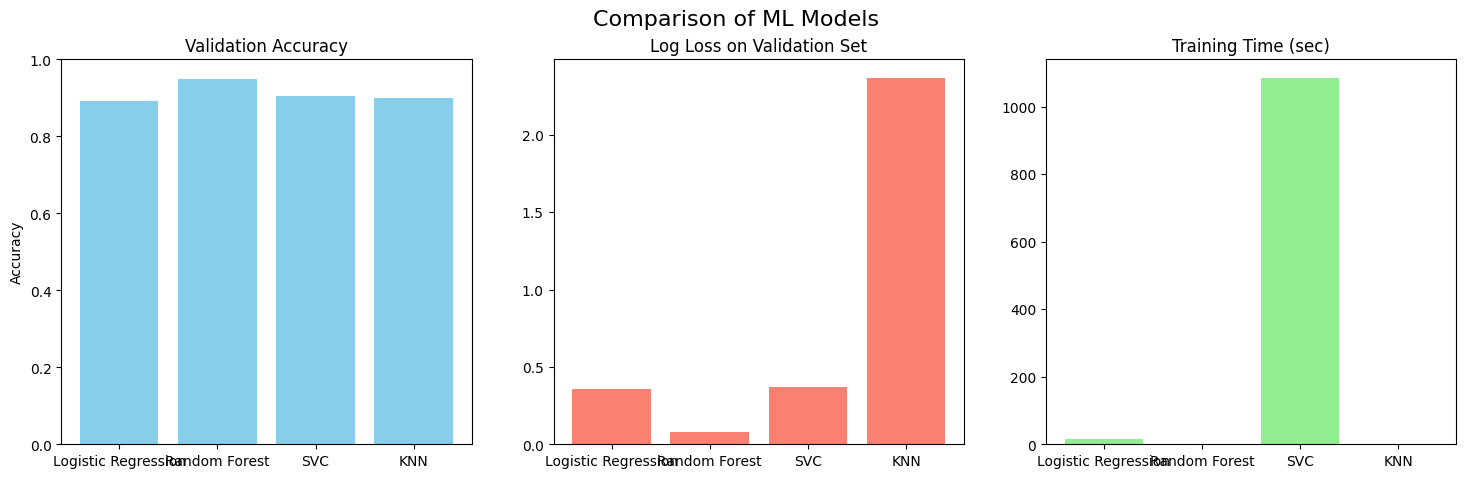

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].bar(models, val_accs, color='skyblue')
axes[0].set_title("Validation Accuracy")
axes[0].set_ylim([0, 1])
axes[0].set_ylabel("Accuracy")

axes[1].bar(models, log_losses, color='salmon')
axes[1].set_title("Log Loss on Validation Set")

axes[2].bar(models, train_times, color='lightgreen')
axes[2].set_title("Training Time (sec)")

plt.suptitle("Comparison of ML Models", fontsize=16)
plt.show()

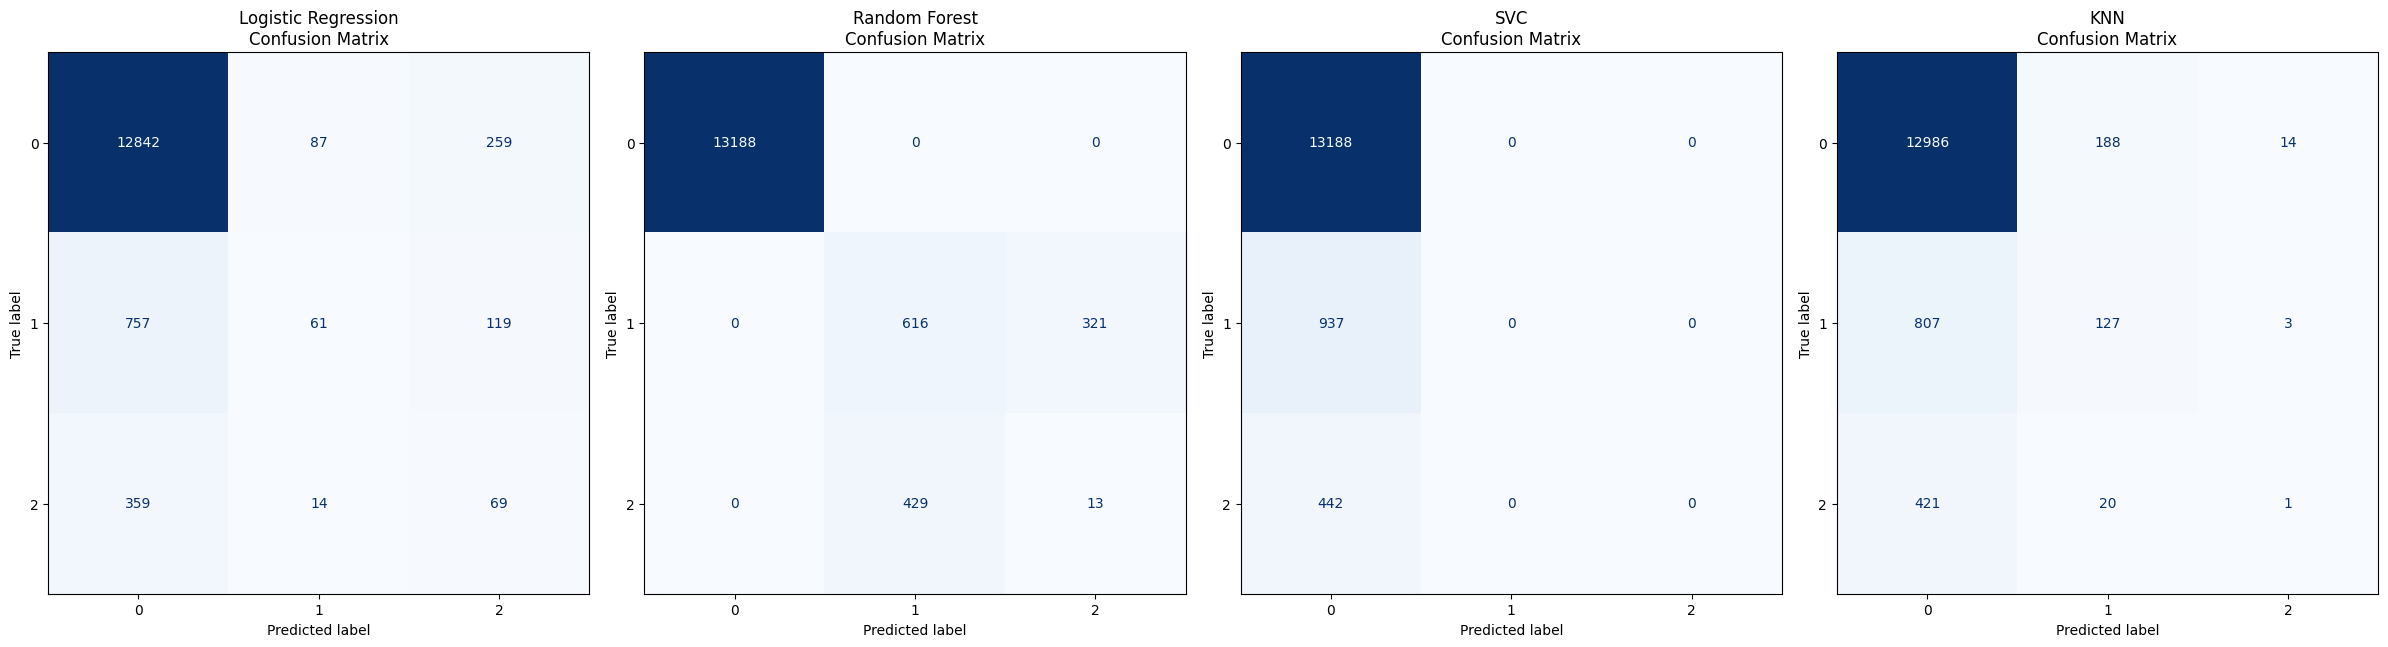

In [38]:
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
cm_log = confusion_matrix(y_validation, pred_val_log)
cm_rf = confusion_matrix(y_validation, pred_val_rf)
cm_svc = confusion_matrix(y_validation, pred_val_svc)
cm_knn = confusion_matrix(y_validation, pred_val_knn)

ConfusionMatrixDisplay(confusion_matrix=cm_log).plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title("Logistic Regression\nConfusion Matrix")

ConfusionMatrixDisplay(confusion_matrix=cm_rf).plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title("Random Forest\nConfusion Matrix")

ConfusionMatrixDisplay(confusion_matrix=cm_svc).plot(ax=axes[2], cmap='Blues', colorbar=False)
axes[2].set_title("SVC\nConfusion Matrix")

ConfusionMatrixDisplay(confusion_matrix=cm_knn).plot(ax=axes[3], cmap='Blues', colorbar=False)
axes[3].set_title("KNN\nConfusion Matrix")

plt.tight_layout()
plt.show()

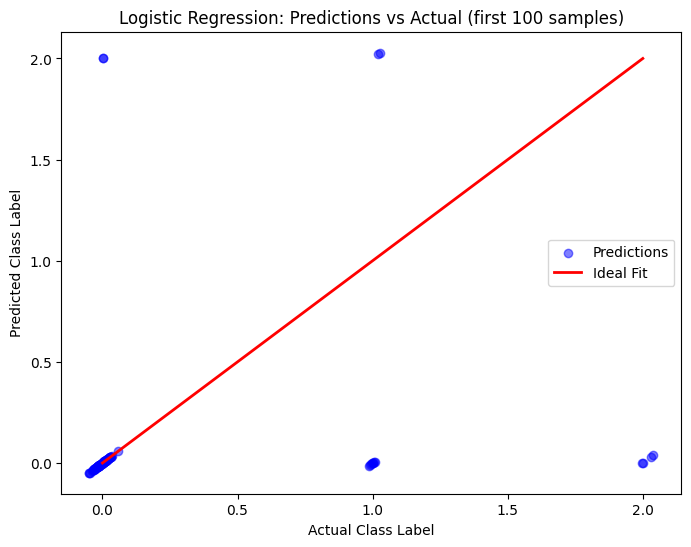

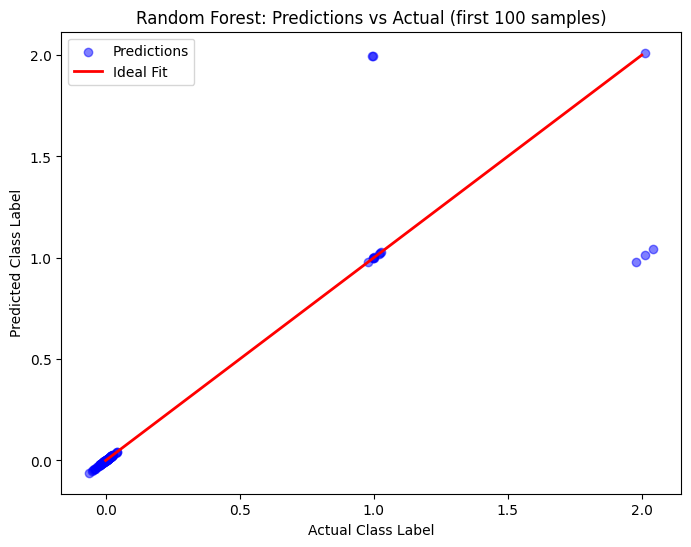

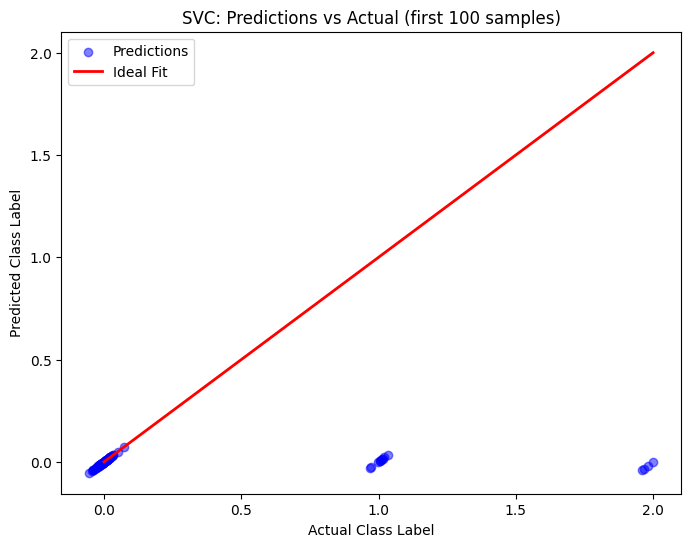

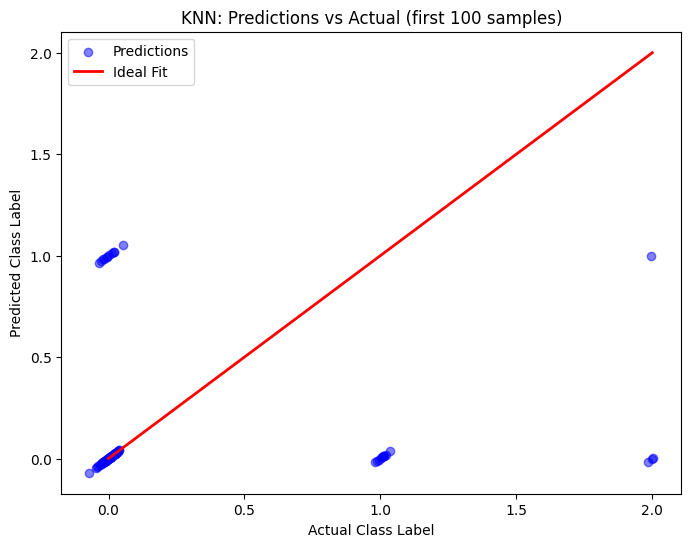

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def plot_classification_results(y_actual, y_pred, model_name, num_samples=100):
    indices = np.arange(min(num_samples, len(y_actual)))
    y_actual = np.array(y_actual[:len(indices)])
    y_pred = np.array(y_pred[:len(indices)])

    plt.figure(figsize=(8, 6))

    jitter = np.random.normal(0, 0.02, size=len(y_actual))
    plt.scatter(y_actual + jitter, y_pred + jitter, color="blue", alpha=0.5, label="Predictions")

    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r', linewidth=2, label="Ideal Fit")

    plt.xlabel("Actual Class Label")
    plt.ylabel("Predicted Class Label")
    plt.title(f"{model_name}: Predictions vs Actual (first {len(indices)} samples)")
    plt.legend()

    plt.show()

plot_classification_results(y_test, pred_test_log, "Logistic Regression")
plot_classification_results(y_test, pred_test_rf, "Random Forest")
plot_classification_results(y_test, pred_test_svc, "SVC")
plot_classification_results(y_test, pred_test_knn, "KNN")


# STEP 3

In [40]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [93]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_numeric = X_train.select_dtypes(include=[np.number])
X_validation_numeric = X_validation.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

input_dim = X_train_numeric.shape[1]  

X_train_tensor = torch.tensor(X_train_numeric.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  
X_validation_tensor = torch.tensor(X_validation_numeric.to_numpy(), dtype=torch.float32)
y_validation_tensor = torch.tensor(y_validation, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_numeric.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [94]:
import torch.nn as nn

class NNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(NNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128) 
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, num_classes)  
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

num_classes = len(np.unique(y_train))
model = NNModel(input_dim, num_classes)


In [95]:
print("Neural Network Model Summary:")
print(model)

Neural Network Model Summary:
NNModel(
  (fc1): Linear(in_features=28, out_features=128, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [96]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [97]:
num_epochs = 50
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

start_time = time.time()

In [98]:
import torch

best_val_loss = float("inf") 

def save_best_nn_model(model, current_loss):
    global best_val_loss
    if current_loss < best_val_loss:  
        best_val_loss = current_loss
        torch.save(model.state_dict(), "best_neural_network.pth")
        print(f"Best NN model saved with validation loss: {current_loss:.4f}")

In [99]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += (preds == labels).sum().item()
        total += inputs.size(0)
    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)
    
    # Validation loop
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += (preds == labels).sum().item()
            val_total += inputs.size(0)
    val_epoch_loss = val_running_loss / val_total
    val_epoch_acc = val_running_corrects / val_total
    val_loss_history.append(val_epoch_loss)
    val_acc_history.append(val_epoch_acc)

    save_best_nn_model(model, val_epoch_loss)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Best NN model saved with validation loss: 0.4316
Epoch 1/50: Train Loss: 6.2876, Train Acc: 0.8824 | Val Loss: 0.4316, Val Acc: 0.9053
Best NN model saved with validation loss: 0.3769
Epoch 2/50: Train Loss: 0.4092, Train Acc: 0.9045 | Val Loss: 0.3769, Val Acc: 0.9053
Best NN model saved with validation loss: 0.3730
Epoch 3/50: Train Loss: 0.3760, Train Acc: 0.9052 | Val Loss: 0.3730, Val Acc: 0.9053
Best NN model saved with validation loss: 0.3726
Epoch 4/50: Train Loss: 0.3766, Train Acc: 0.9052 | Val Loss: 0.3726, Val Acc: 0.9053
Best NN model saved with validation loss: 0.3725
Epoch 5/50: Train Loss: 0.3760, Train Acc: 0.9052 | Val Loss: 0.3725, Val Acc: 0.9053
Epoch 6/50: Train Loss: 0.3762, Train Acc: 0.9053 | Val Loss: 0.3726, Val Acc: 0.9053
Best NN model saved with validation loss: 0.3725
Epoch 7/50: Train Loss: 0.3767, Train Acc: 0.9052 | Val Loss: 0.3725, Val Acc: 0.9053
Best NN model saved with validation loss: 0.3725
Epoch 8/50: Train Loss: 0.3731, Train Acc: 0.9053 | Val

In [101]:
val_loss = criterion(model(X_validation_tensor), y_validation_tensor)
save_best_nn_model(model, val_loss.item())

In [47]:
torch.save(model.state_dict(), "neural_network_weights.pth")
print("Neural Network weights saved successfully!")

Neural Network weights saved successfully!


In [48]:
nn_train_time = time.time() - start_time

In [49]:
model.eval()
test_running_loss = 0.0
test_running_corrects = 0
test_total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        test_running_corrects += (preds == labels).sum().item()
        test_total += inputs.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = test_running_loss / test_total
test_acc = test_running_corrects / test_total

print("\nNeural Network Test Loss:", test_loss)
print("Neural Network Test Accuracy:", test_acc)
print("Neural Network Training Time (sec):", nn_train_time)
print("\nClassification Report (Neural Network):")
print(classification_report(all_labels, all_preds))



Neural Network Test Loss: 0.36988243053962344
Neural Network Test Accuracy: 0.9052718286655683
Neural Network Training Time (sec): 22.376885890960693

Classification Report (Neural Network):
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3297
           1       0.00      0.00      0.00       235
           2       0.00      0.00      0.00       110

    accuracy                           0.91      3642
   macro avg       0.30      0.33      0.32      3642
weighted avg       0.82      0.91      0.86      3642



/Users/sruthisriv/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sruthisriv/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sruthisriv/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [50]:
model.eval()  
all_nn_preds = []
all_y_test = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_nn_preds.extend(preds.cpu().numpy())
        all_y_test.extend(labels.cpu().numpy())

nn_pred = np.array(all_nn_preds)
y_test_labels = np.array(all_y_test)

In [51]:
print("pred_test_log shape:", np.array(pred_test_log).shape)
print("pred_test_rf shape:", np.array(pred_test_rf).shape)
print("pred_test_svc shape:", np.array(pred_test_svc).shape)
print("pred_test_knn shape:", np.array(pred_test_knn).shape)
print("nn_pred shape:", nn_pred.shape)
print("y_test_labels shape:", y_test_labels.shape)

pred_test_log shape: (3642,)
pred_test_rf shape: (3642,)
pred_test_svc shape: (3642,)
pred_test_knn shape: (3642,)
nn_pred shape: (3642,)
y_test_labels shape: (3642,)


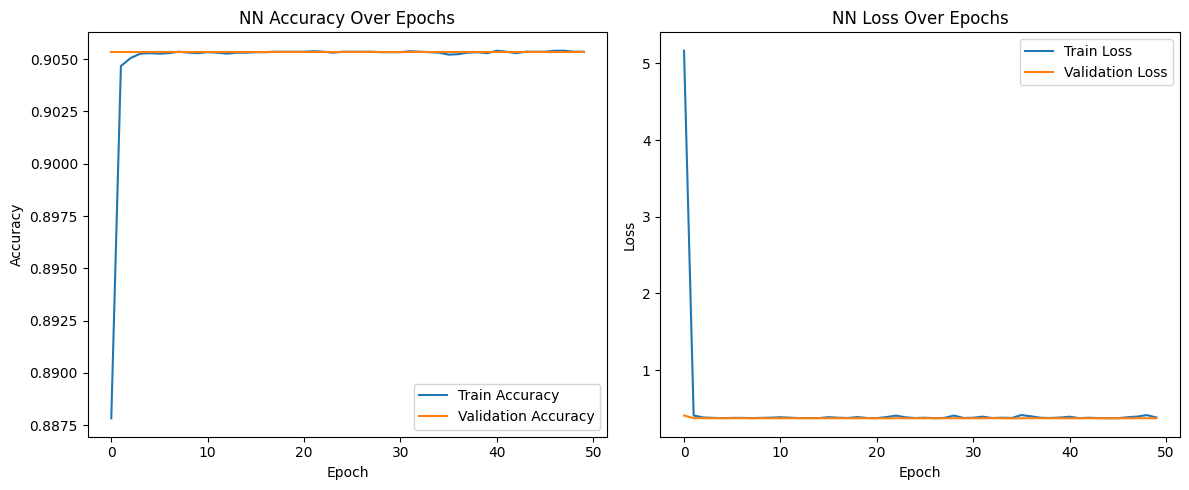

In [52]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title("NN Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title("NN Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

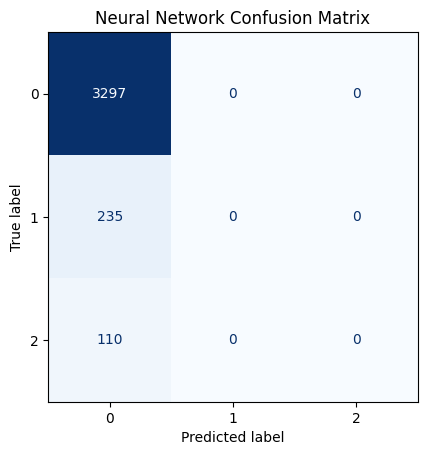

In [53]:
cm_nn = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(confusion_matrix=cm_nn).plot(cmap='Blues', colorbar=False)
plt.title("Neural Network Confusion Matrix")
plt.show()

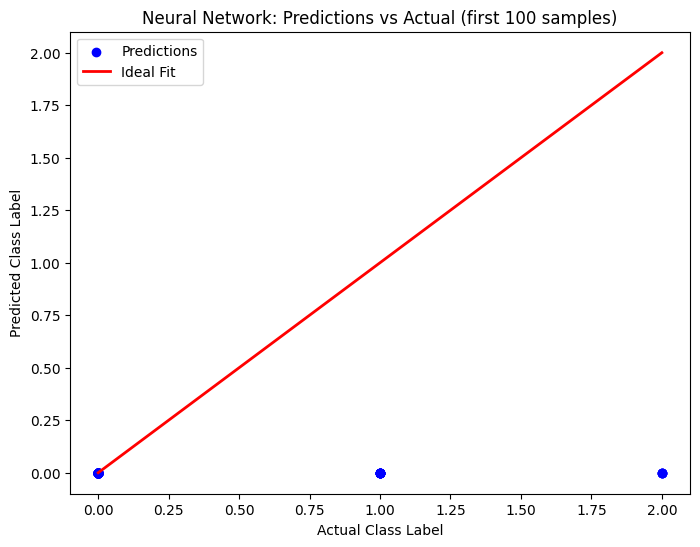

In [54]:
nn_pred = np.array(nn_pred) 
y_test_labels = np.array(y_test_labels) 

plt.figure(figsize=(8,6))
plt.scatter(y_test_labels[:100], nn_pred[:100], color='blue', label='Predictions')  # Plot first 100 samples
plt.plot([0, max(y_test_labels)], [0, max(y_test_labels)], color='red', linewidth=2, label='Ideal Fit')  # Diagonal line

plt.xlabel("Actual Class Label")
plt.ylabel("Predicted Class Label")
plt.title("Neural Network: Predictions vs Actual (first 100 samples)")
plt.legend()
plt.show()

In [55]:

results['Model'].append('Neural Network (PyTorch)')
results['Train Time (sec)'].append(nn_train_time)
results['Train Accuracy'].append(train_acc_history[-1])  
results['Validation Accuracy'].append(test_acc)          
results['Log Loss'].append(test_loss)



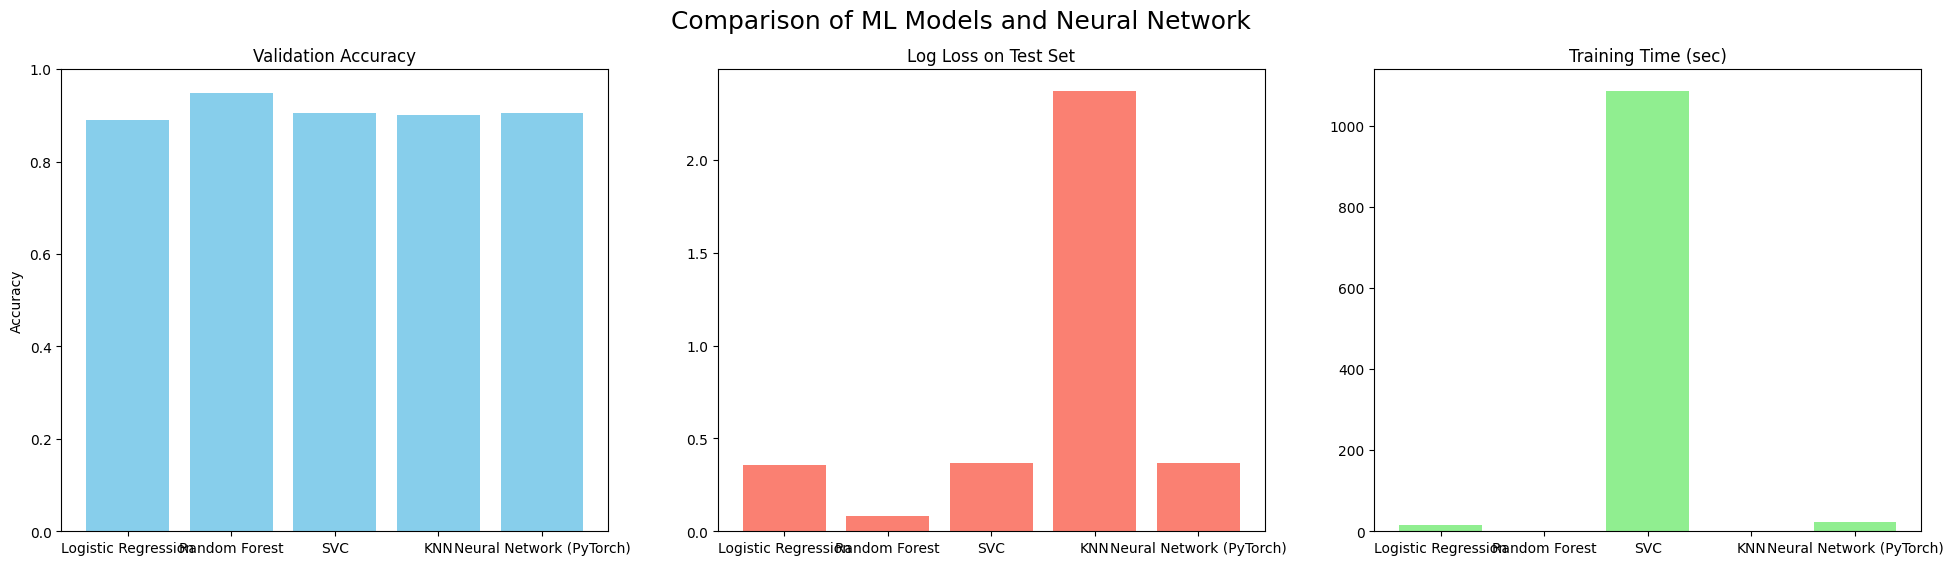

In [56]:
models = np.array(results['Model'])
train_times = np.array(results['Train Time (sec)'])
val_accs = np.array(results['Validation Accuracy'])
log_losses = np.array(results['Log Loss'])

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

axes[0].bar(models, val_accs, color='skyblue')
axes[0].set_title("Validation Accuracy")
axes[0].set_ylim([0, 1])
axes[0].set_ylabel("Accuracy")

axes[1].bar(models, log_losses, color='salmon')
axes[1].set_title("Log Loss on Test Set")

axes[2].bar(models, train_times, color='lightgreen')
axes[2].set_title("Training Time (sec)")

plt.suptitle("Comparison of ML Models and Neural Network", fontsize=18)
plt.show()

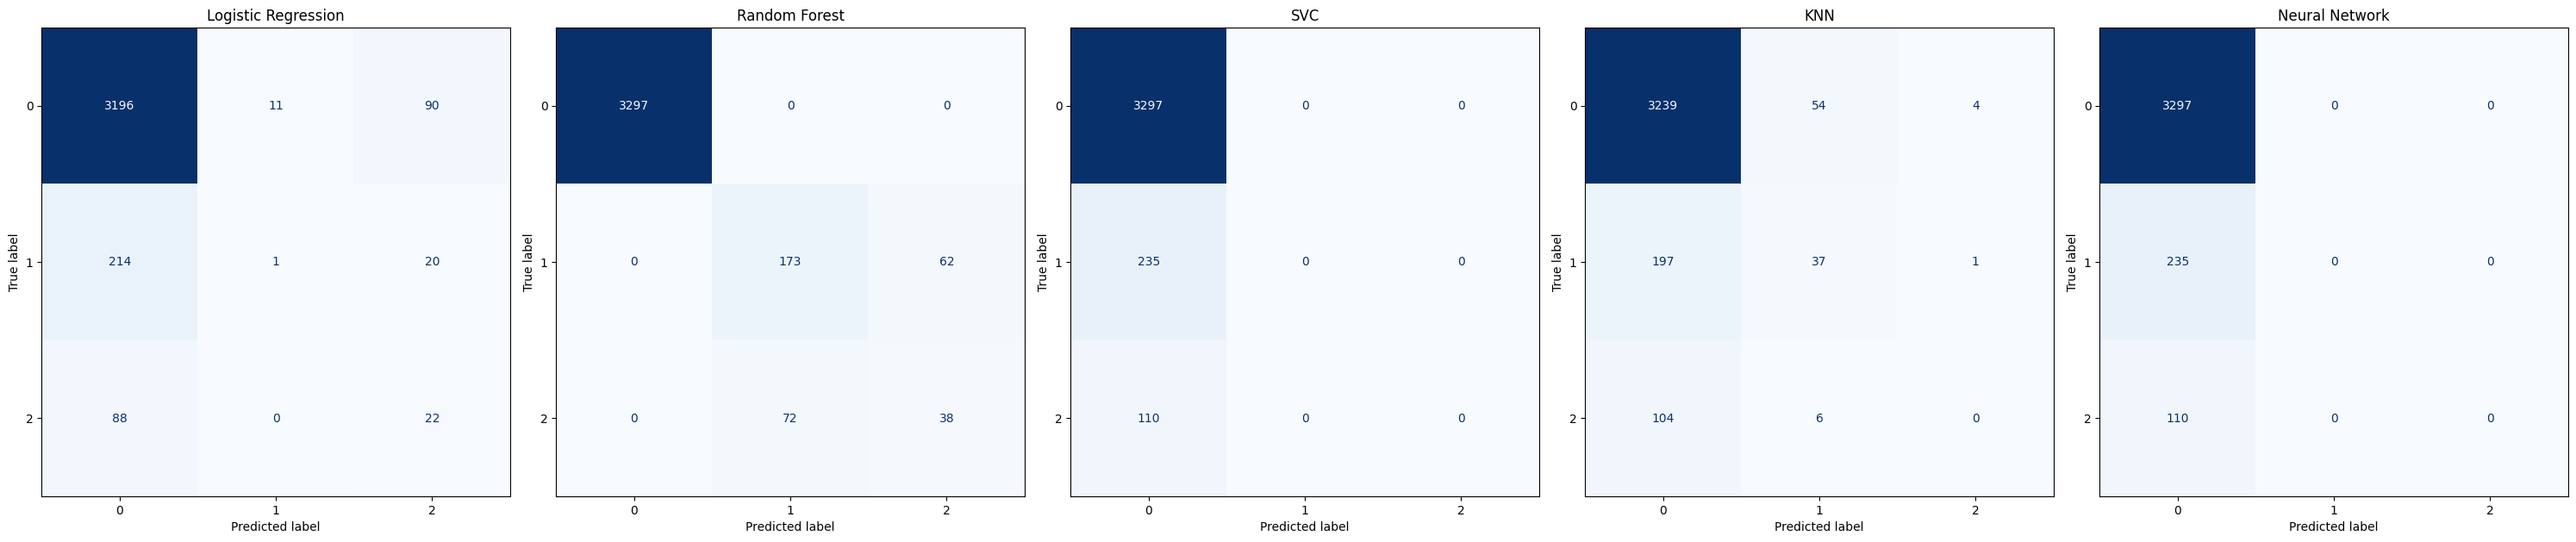

In [57]:
cm_log = confusion_matrix(y_test, pred_test_log)
cm_rf = confusion_matrix(y_test, pred_test_rf)
cm_svc = confusion_matrix(y_test, pred_test_svc)
cm_knn = confusion_matrix(y_test, pred_test_knn)
cm_nn = confusion_matrix(y_test_labels, nn_pred)

fig, axes = plt.subplots(1, 5, figsize=(30, 6))

ConfusionMatrixDisplay(confusion_matrix=cm_log).plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title("Logistic Regression")

ConfusionMatrixDisplay(confusion_matrix=cm_rf).plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title("Random Forest")

ConfusionMatrixDisplay(confusion_matrix=cm_svc).plot(ax=axes[2], cmap='Blues', colorbar=False)
axes[2].set_title("SVC")

ConfusionMatrixDisplay(confusion_matrix=cm_knn).plot(ax=axes[3], cmap='Blues', colorbar=False)
axes[3].set_title("KNN")

ConfusionMatrixDisplay(confusion_matrix=cm_nn).plot(ax=axes[4], cmap='Blues', colorbar=False)
axes[4].set_title("Neural Network")

plt.tight_layout()
plt.show()

In [58]:
torch.save(model.state_dict(), 'nn_model_weights.pth')
print("Weights saved!")

Weights saved!
